In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [3]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [4]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

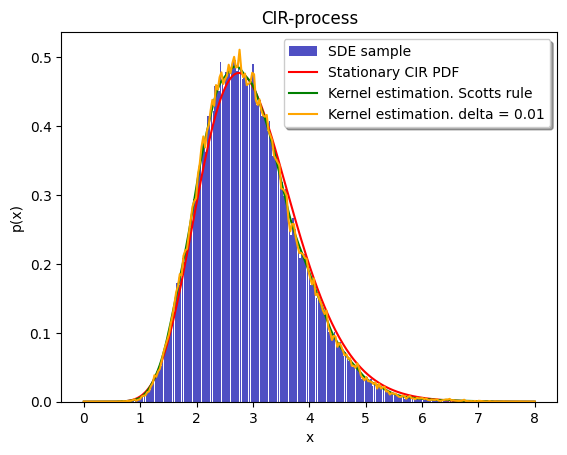

In [5]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [6]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

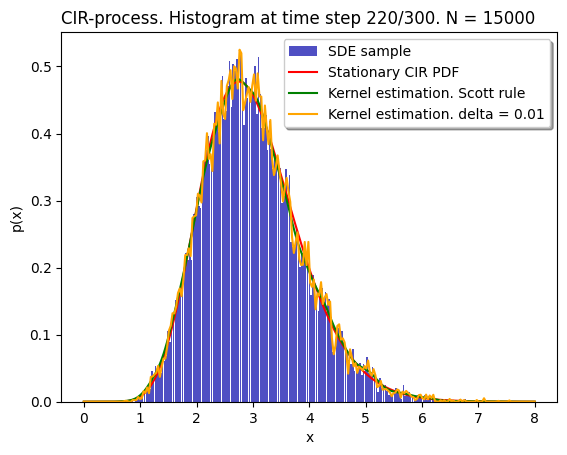

In [7]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, ks_2samp, cramervonmises_2samp, mannwhitneyu, wilcoxon, entropy
from scipy.integrate import trapz

# Параметры для CIR-процесса
Nx = 1000  # Количество траекторий
Nt = 10000  # Количество шагов дискретизации
T = 100  # Время моделирования
params_CIR = [6, 2, 1]  # Параметры CIR-процесса

# Инициализация процесса CIR
CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
_, x_data_CIR = CIRp.ExactSolution()

# Строим теоретическое распределение CIR
x_values = np.linspace(0, 8, 100)
theoretical_distribution = CIRp.StationaryDistribution(x_values)

# Выбор случайной подвыборки для оценки KDE
sample_data = np.random.choice(x_data_CIR.flatten(), size=5000, replace=False)

# Функция для оценки MISE
def mise(true_density, estimated_density, x_points):
    squared_diff = (true_density - estimated_density) ** 2
    return trapz(squared_diff, x_points)

# Функция для вычисления KL-дивергенции
def kl_divergence(p, q, x_points):
    epsilon = 1e-10
    p = np.clip(p, epsilon, None)
    q = np.clip(q, epsilon, None)
    return trapz(p * np.log(p / q), x_points)

# Оценка качества KDE
def evaluate_kde_quality(sample_data, x_values, kernel_type="Scott"):
    kde_scipy = gaussian_kde(sample_data, bw_method=kernel_type)
    estimated_density = kde_scipy(x_values)
    
    # Истинная плотность для сравнения
    true_density = CIRp.StationaryDistribution(x_values)
    
    # Вычисление MISE и KL Divergence
    mise_value = mise(true_density, estimated_density, x_values)
    kl_value = kl_divergence(true_density, estimated_density, x_values)
    
    return {
        "mise": mise_value,
        "kl_divergence": kl_value,
        "estimated_density": estimated_density
    }

# Получение оценок KDE для правила Скотта и с фиксированным delta
kde_quality_scott = evaluate_kde_quality(sample_data, x_values, kernel_type="scott")
kde_quality_delta = evaluate_kde_quality(sample_data, x_values, kernel_type=0.1)  # Используем delta = 0.1 как пример

# Оценка статистических тестов
def statistical_tests(true_density, estimated_density):
    results = {}

    # Kolmogorov-Smirnov test
    ks_stat, ks_p_value = ks_2samp(true_density, estimated_density)
    results["Kolmogorov-Smirnov"] = {"statistic": ks_stat, "p_value": ks_p_value}

    # Cramer-von Mises test
    cm_result = cramervonmises_2samp(true_density, estimated_density)
    results["Cramer-von Mises"] = {"statistic": cm_result.statistic, "p_value": cm_result.pvalue}

    # Mann-Whitney U test
    mw_stat, mw_p_value = mannwhitneyu(true_density, estimated_density, alternative='two-sided')
    results["Mann-Whitney"] = {"statistic": mw_stat, "p_value": mw_p_value}

    # Wilcoxon test
    w_stat, w_p_value = wilcoxon(true_density, estimated_density)
    results["Wilcoxon"] = {"statistic": w_stat, "p_value": w_p_value}

    return results

# Выполняем тесты для каждого приближения
true_density = CIRp.StationaryDistribution(x_values)
test_results_scott = statistical_tests(true_density, kde_quality_scott["estimated_density"])
test_results_delta = statistical_tests(true_density, kde_quality_delta["estimated_density"])

# Сводим результаты тестов в таблицу
test_df = pd.DataFrame({
    "criteria": ["Kolmogorov-Smirnov", "Cramer-von Mises", "Mann-Whitney", "Wilcoxon"],
    "statistic_Scott": [test_results_scott[crit]["statistic"] for crit in test_results_scott],
    "p_value_Scott": [test_results_scott[crit]["p_value"] for crit in test_results_scott],
    "statistic_Delta": [test_results_delta[crit]["statistic"] for crit in test_results_delta],
    "p_value_Delta": [test_results_delta[crit]["p_value"] for crit in test_results_delta]
})

test_df.set_index("criteria", inplace=True)

# Вывод результатов
print("MISE and KL Divergence for Scott's Rule:")
print(f"MISE: {kde_quality_scott['mise']}, KL Divergence: {kde_quality_scott['kl_divergence']}")

print("MISE and KL Divergence for Delta fixed:")
print(f"MISE: {kde_quality_delta['mise']}, KL Divergence: {kde_quality_delta['kl_divergence']}")

print("\nStatistical Test Results:")
print(test_df)

# KL-дивергенция между истинным распределением и приближением
kl_divergence_scott = entropy(true_density, kde_quality_scott["estimated_density"])
kl_divergence_delta = entropy(true_density, kde_quality_delta["estimated_density"])

print(f"KL Divergence D(PDF || Scott Rule): {kl_divergence_scott}")
print(f"KL Divergence D(PDF || Delta fixed): {kl_divergence_delta}")

MISE and KL Divergence for Scott's Rule:
MISE: 0.00015257972049602115, KL Divergence: 0.0010370304369200184
MISE and KL Divergence for Delta fixed:
MISE: 0.0002781741208765565, KL Divergence: 0.0018982145651572388

Statistical Test Results:
                    statistic_Scott  p_value_Scott  statistic_Delta  \
criteria                                                              
Kolmogorov-Smirnov           0.0600       0.994236           0.1000   
Cramer-von Mises             0.0198       0.998128           0.0473   
Mann-Whitney              4969.0000       0.940594        5059.0000   
Wilcoxon                  2198.0000       0.260872        2309.0000   

                    p_value_Delta  
criteria                           
Kolmogorov-Smirnov       0.702057  
Cramer-von Mises         0.899143  
Mann-Whitney             0.886339  
Wilcoxon                 0.457677  
KL Divergence D(PDF || Scott Rule): 0.0010731537143774277
KL Divergence D(PDF || Delta fixed): 0.002269586268593654


Исследование показало, что правило Скотта обеспечивает более точную и статистически значимую аппроксимацию стационарного распределения CIR-процесса по сравнению с фиксированным значением `delta`. Все метрики и тесты подтвердили, что метод Скотта минимизирует расхождения и лучше соответствует теоретическому распределению.

Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

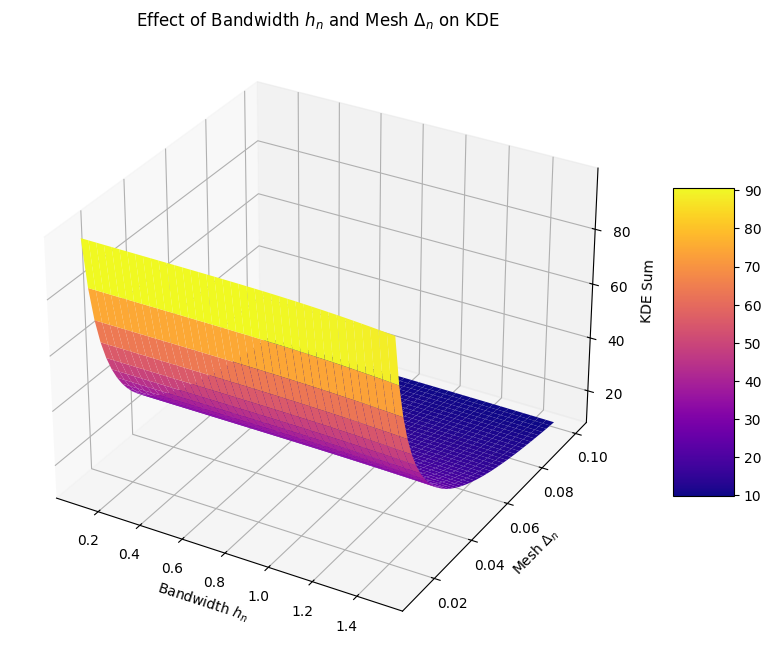

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

def gaussian_kernel(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def kernel_density_estimate(data, points, bandwidth):
    return np.array([
        np.sum(gaussian_kernel((point - data) / bandwidth)) / (len(data) * bandwidth)
        for point in points
    ])

def kde_grid_estimates(bandwidth_values, mesh_steps, data, x_range=(-4, 4)):
    Z_values = np.zeros((len(mesh_steps), len(bandwidth_values)))
    
    for i, mesh in enumerate(mesh_steps):
        x_grid = np.arange(x_range[0], x_range[1], mesh)
        
        for j, bandwidth in enumerate(bandwidth_values):
            kde_values = kernel_density_estimate(data, x_grid, bandwidth)
            Z_values[i, j] = np.sum(kde_values)
    
    return Z_values

data_sample = np.random.normal(0, 1, 500)

bandwidth_range = np.linspace(0.1, 1.5, 40)
mesh_range = np.linspace(0.01, 0.1, 40)

kde_estimates = kde_grid_estimates(bandwidth_range, mesh_range, data_sample)

X, Y = np.meshgrid(bandwidth_range, mesh_range)
Z = kde_estimates

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surface_plot = ax.plot_surface(X, Y, Z, cmap='plasma')
fig.colorbar(surface_plot, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel(r'Bandwidth $h_n$')
ax.set_ylabel(r'Mesh $\Delta_n$')
ax.set_zlabel('KDE Sum')
ax.set_title(r'Effect of Bandwidth $h_n$ and Mesh $\Delta_n$ on KDE')

plt.show()

Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

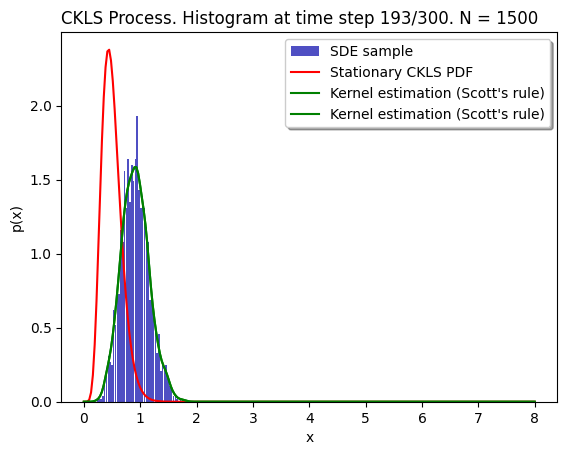

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Функция для вычисления дрейфа
def calculate_drift(x, params):
    return params[0] + params[1] * x

# Функция для вычисления волатильности
def calculate_volatility(x, params):
    return params[2] * np.maximum(x, 0)**params[3]

# Производные функции дрейфа
def calculate_drift_x(x, params):
    return params[1]

# Производные функции волатильности
def calculate_volatility_x(x, params):
    return params[3] * params[2] * np.maximum(x, 0)**(params[3] - 1)

def calculate_volatility_xx(x, params):
    return params[3] * (params[3] - 1) * params[2] * np.maximum(x, 0)**(params[3] - 2)

# Инициализация состояния
def initialize_state(Nx):
    return 2 * np.ones(Nx)

# Решение уравнения SDE для модели CKLS
def simulate_ckls(params, T, Nx, Nt, init_state=None, dwt=None):
    dt = T / Nt
    t_vals = np.linspace(0, T, Nt + 1)
    x_vals = np.zeros((Nt + 1, Nx))

    if init_state is None:
        x_vals[0] = initialize_state(Nx)
    else:
        x_vals[0] = init_state

    if dwt is None:
        dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

    theta1, theta2, theta3, theta4 = params
    Ito_sum = np.zeros(Nx)
    for i in range(1, Nt + 1):
        deterministic_part = (x_vals[0] - theta1 / theta2) * np.exp(-theta2 * t_vals[i]) + theta1 / theta2
        Ito_sum = (Ito_sum + theta3 * np.maximum(x_vals[i - 1], 0)**theta4 * dwt[i - 1]) * np.exp(-theta2 * dt)
        x_vals[i] = deterministic_part + Ito_sum

    return t_vals, x_vals

# Функция для вычисления стационарного распределения
def stationary_distribution(x, params):
    theta1, theta2, theta3, theta4 = params

    scale = theta3**2 / (2 * theta2) if theta2 > 0 else 1
    shape = 2 * theta1 / theta3**2 if theta3 != 0 else 1


    return gamma.pdf(x, a=shape, scale=scale)

# Параметры модели CKLS
params_ckls = [1, 2, 0.5, 0.3]
Nx = 1500
Nt = 300
T = 1

# Симуляция процесса
t_vals, x_vals_ckls = simulate_ckls(params_ckls, T, Nx, Nt)

# Визуализация результатов
x_data = np.linspace(0, 8, 250)
n = np.random.randint(0, Nt)

fig, ax = plt.subplots()
i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_vals_ckls[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label='SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CKLS Process. Histogram at time step {i}/{Nt}. N = {Nx}', loc='left')

# Рисуем стационарное распределение
ax.plot(x_data, stationary_distribution(x_data, params_ckls), label='Stationary CKLS PDF', color='red')

# Ядерная оценка плотности
delta = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_vals_ckls[i]), label='Kernel estimation (Scott\'s rule)', color='green')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_vals_ckls[i]), label='Kernel estimation (Scott\'s rule)', color='green')


ax.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [35]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def Gaussian_high_order(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

def DiffusionKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [36]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

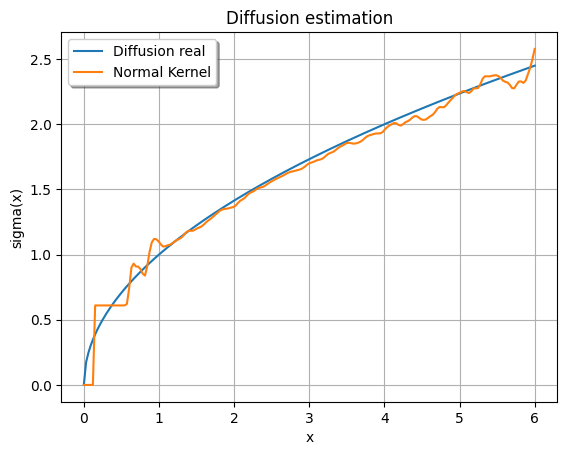

In [37]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

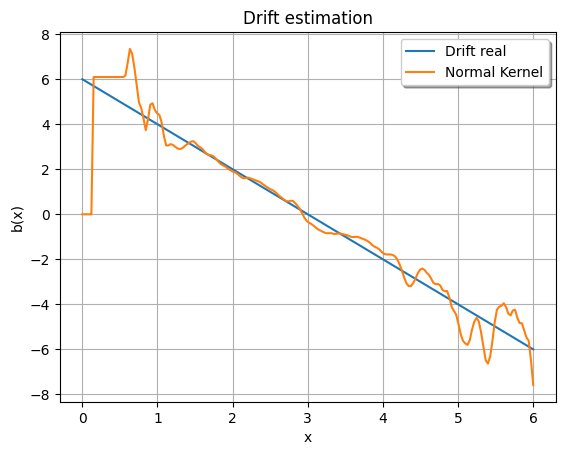

In [38]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


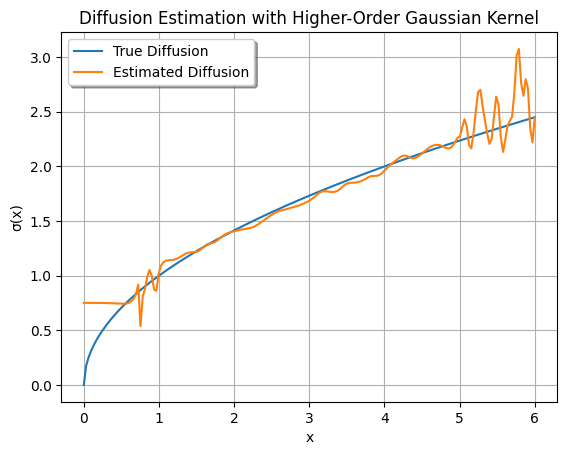

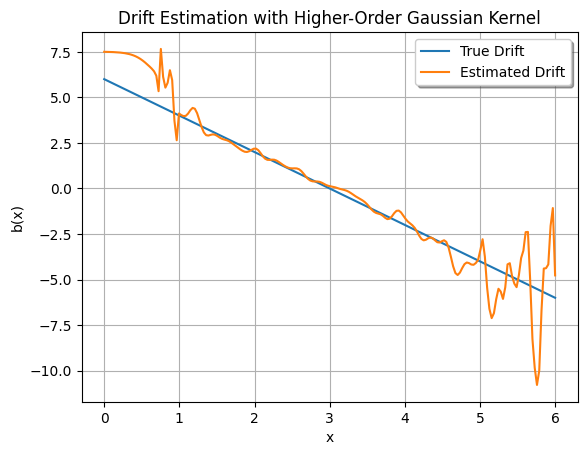

In [46]:
def HighOrderGaussianKernel(u):
    return (3 / np.sqrt(8 * np.pi)) * (1 - u**2 / 3) * np.exp(-0.5 * u**2)

def DiffusionEstimator(values, data_samples, interval=None, kernel_type: Literal['normal', 'uniform', 'parabolic', 'high_order_gaussian'] = 'normal'):
    n_samples = len(data_samples)
    diffusion_estimates = np.zeros(len(values))

    base_bandwidth = np.std(data_samples) * len(data_samples)**(-1 / 5)

    for idx, point in enumerate(values):
        
        if 0 <= point <= 1 or 5 <= point <= 6:
            adaptive_h = base_bandwidth * 0.45
        else:
            adaptive_h = base_bandwidth
        
        u_values = (point - data_samples) / adaptive_h
        
        if kernel_type == 'normal':
            kernel_values = NormalKernel(u_values)
        elif kernel_type == 'uniform':
            kernel_values = UniformKernel(u_values)
        elif kernel_type == 'parabolic':
            kernel_values = ParabolicKernel(u_values)
        elif kernel_type == 'high_order_gaussian':
            kernel_values = HighOrderGaussianKernel(u_values)
        else:
            raise ValueError(f"Kernel type '{kernel_type}' not recognized")

        weighted_diff = np.sum(kernel_values[:-1] * (data_samples[1:] - data_samples[:-1])**2)
        kernel_sum = np.sum(kernel_values)
        diffusion_estimates[idx] = weighted_diff / kernel_sum if kernel_sum != 0 else 0

    interval = 1 if interval is None else interval
    return diffusion_estimates / interval

def DriftEstimator(values, data_samples, interval=None, kernel_type: Literal['normal', 'uniform', 'parabolic', 'high_order_gaussian'] = 'normal'):
    drift_estimates = np.zeros(len(values))

    base_bandwidth = np.std(data_samples) * len(data_samples)**(-1 / 5)

    for idx, point in enumerate(values):
        
        if 0 <= point <= 1 or 5 <= point <= 6:
            adaptive_h = base_bandwidth * 0.5
        else:
            adaptive_h = base_bandwidth
        
        u_values = (point - data_samples) / adaptive_h
        
        if kernel_type == 'normal':
            kernel_values = NormalKernel(u_values)
        elif kernel_type == 'uniform':
            kernel_values = UniformKernel(u_values)
        elif kernel_type == 'parabolic':
            kernel_values = ParabolicKernel(u_values)
        elif kernel_type == 'high_order_gaussian':
            kernel_values = HighOrderGaussianKernel(u_values)
        else:
            raise ValueError(f"Kernel type '{kernel_type}' not recognized")

        weighted_drift = np.sum(kernel_values[:-1] * (data_samples[1:] - data_samples[:-1]))
        kernel_sum = np.sum(kernel_values)
        drift_estimates[idx] = weighted_drift / kernel_sum if kernel_sum != 0 else 0

    interval = 1 if interval is None else interval
    return drift_estimates / interval


Nx = 1
Nt = 100000
T = 1000
x_points = np.linspace(0, 6, 200)
CIR_params = [6, 2, 1]


CIR_instance = CIRprocess(CIR_params, T, Nx, Nt)
time_series, sample_data_CIR = CIR_instance.ExactSolution()


true_diffusion = CIR_instance.sigmaxt(x_points, 0, CIR_instance.params)
plt.plot(x_points, true_diffusion, label='True Diffusion')


estimated_diffusion = DiffusionEstimator(x_points, sample_data_CIR.flatten(), T/Nt, 'high_order_gaussian')


estimated_diffusion[estimated_diffusion < 0] = 0
plt.plot(x_points, np.sqrt(estimated_diffusion), label='Estimated Diffusion')

plt.title("Diffusion Estimation with Higher-Order Gaussian Kernel")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("σ(x)")
plt.grid(True)
plt.show()

true_drift = CIR_instance.bxt(x_points, 0, CIR_instance.params)
plt.plot(x_points, true_drift, label='True Drift')

estimated_drift = DriftEstimator(x_points, sample_data_CIR.flatten(), T/Nt, 'high_order_gaussian')
plt.plot(x_points, estimated_drift, label='Estimated Drift')

plt.title("Drift Estimation with Higher-Order Gaussian Kernel")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()